### https://arxiv.org/pdf/2402.08593

In [1]:
import json
import random
import os
import pickle
import time
import shutil
import sys
import uuid
from collections import defaultdict
from datetime import timedelta
from glob import glob
from itertools import product
from pyspark.sql import functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, RocCurveDisplay

from sklearn.preprocessing import normalize

import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd
import xgboost as xgb

import settings as s

assert s.FILE_SIZE == "Small"
assert s.HIGH_ILLICIT == False

os.environ["EXT_DATA_TYPE_FOLDER"] = s.OUTPUT_POSTFIX.lstrip("-")

from common import get_weights, delete_large_vars, MULTI_PROC_STAGING_LOCATION
from communities import get_communities_spark
from features import (
    generate_features_spark, generate_features_udf_wrapper, get_edge_features_udf,
    SCHEMA_FEAT_UDF, CURRENCY_RATES
)

%load_ext autoreload
%autoreload 2

In [3]:
start_script = time.time()

In [4]:
if (
    sys.version_info.major,
    sys.version_info.minor,
    sys.version_info.micro,
) != (3, 11, 8):
    raise EnvironmentError(
        "Only runs efficiently on Python 3.11.8 (Tested on: Conda 24.1.2 | Apple M3 Pro)"
    )

In [5]:
SPARK_CONF = [
    ("spark.driver.memory", "32g"),
    ("spark.worker.memory", "32g"),
    ("spark.driver.maxResultSize", "32g"),
    ("spark.driver.bindAddress", "127.0.0.1"),
    ("spark.sql.execution.arrow.pyspark.enabled", "true"),
    ("spark.network.timeout", "600s"),
    ("spark.sql.autoBroadcastJoinThreshold", -1)
]

shutil.rmtree("artifacts", ignore_errors=True)
spark = (
    SparkSession.builder.appName("testing")
    .config(conf=SparkConf().setAll(SPARK_CONF))
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/25 17:02:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
TRAIN_PERC = 0.6
VALIDATION_PERC = 0.2
TEST_PERC = 0.2

KEEP_TOP_N = 100

assert(sum([TRAIN_PERC, VALIDATION_PERC, TEST_PERC]) == 1)

location_main = os.path.join("features", os.environ["EXT_DATA_TYPE_FOLDER"])
# shutil.rmtree(location_main, ignore_errors=True)

location_communities_leiden = f"{location_main}{os.sep}communities_leiden.parquet"

location_features_leiden = f"{location_main}{os.sep}features_leiden.parquet"
location_features_ego = f"{location_main}{os.sep}features_ego.parquet"
location_features_2_hop = f"{location_main}{os.sep}features_2_hop.parquet"
location_features_2_hop_out = f"{location_main}{os.sep}features_2_hop_out.parquet"
location_features_2_hop_in = f"{location_main}{os.sep}features_2_hop_in.parquet"
location_features_2_hop_combined = f"{location_main}{os.sep}features_2_hop_combined.parquet"
location_features_source = f"{location_main}{os.sep}features_source.parquet"
location_features_target = f"{location_main}{os.sep}features_target.parquet"

location_flow_dispense = f"{location_main}{os.sep}location_flow_dispense.parquet"
location_flow_passthrough = f"{location_main}{os.sep}location_flow_passthrough.parquet"
location_flow_sink = f"{location_main}{os.sep}location_flow_sink.parquet"

location_comm_as_source_features = f"{location_main}{os.sep}comm_as_source_features.parquet"
location_comm_as_target_features = f"{location_main}{os.sep}comm_as_target_features.parquet"
location_comm_as_passthrough_features = f"{location_main}{os.sep}comm_as_passthrough_features.parquet"
location_comm_as_passthrough_features_reverse = f"{location_main}{os.sep}comm_as_passthrough_features_reverse.parquet"

location_features_node_level = f"{location_main}{os.sep}features_node_level.parquet"
location_features_edges = f"{location_main}{os.sep}features_edges.parquet"

location_features_edges_train = f"{location_main}{os.sep}features_edges_train.parquet"
location_features_edges_valid = f"{location_main}{os.sep}features_edges_valid.parquet"
location_features_edges_test = f"{location_main}{os.sep}features_edges_test.parquet"

location_train_trx_features = f"{location_main}{os.sep}train_trx_features.parquet"
location_valid_trx_features = f"{location_main}{os.sep}valid_trx_features.parquet"
location_test_trx_features = f"{location_main}{os.sep}test_trx_features.parquet"

location_train_features = f"{location_main}{os.sep}train_features.parquet"
location_valid_features = f"{location_main}{os.sep}valid_features.parquet"
location_test_features = f"{location_main}{os.sep}test_features.parquet"

try:
    os.makedirs(location_main)
except FileExistsError:
    pass

In [31]:
data = spark.read.parquet(s.STAGED_DATA_LOCATION)
data = data.withColumn("is_laundering", sf.col("is_laundering").cast("boolean"))
data_count_original = data.count()

In [32]:
%%time

trx_ids_sorted = data.sort("timestamp").select("transaction_id").toPandas()["transaction_id"].values
trx_count = len(trx_ids_sorted)

last_train_index = int(np.floor(trx_count * TRAIN_PERC))
last_validation_index = last_train_index + int(np.floor(trx_count * VALIDATION_PERC))
train_indexes = trx_ids_sorted[:last_train_index]
validation_indexes = trx_ids_sorted[last_train_index:last_validation_index]
test_indexes = trx_ids_sorted[last_validation_index:]

train_indexes = spark.createDataFrame(
    pd.DataFrame(train_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)
validation_indexes = spark.createDataFrame(
    pd.DataFrame(validation_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)
test_indexes = spark.createDataFrame(
    pd.DataFrame(test_indexes, columns=["transaction_id"])
).persist(StorageLevel.DISK_ONLY)

train = train_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
validation = validation_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
test = test_indexes.join(
    data, on="transaction_id", how="left"
).persist(StorageLevel.DISK_ONLY)
train_count, validation_count, test_count = train.count(), validation.count(), test.count()
print()
print(trx_count, train_count, validation_count, test_count)
print()

25/07/25 17:21:20 WARN TaskSetManager: Stage 11 contains a task of very large size (11150 KiB). The maximum recommended task size is 1000 KiB.
25/07/25 17:21:22 WARN TaskSetManager: Stage 13 contains a task of very large size (11150 KiB). The maximum recommended task size is 1000 KiB.
25/07/25 17:21:27 WARN TaskSetManager: Stage 24 contains a task of very large size (3723 KiB). The maximum recommended task size is 1000 KiB.
25/07/25 17:21:28 WARN TaskSetManager: Stage 26 contains a task of very large size (3723 KiB). The maximum recommended task size is 1000 KiB.
25/07/25 17:21:30 WARN TaskSetManager: Stage 37 contains a task of very large size (3723 KiB). The maximum recommended task size is 1000 KiB.
25/07/25 17:21:31 WARN TaskSetManager: Stage 39 contains a task of very large size (3723 KiB). The maximum recommended task size is 1000 KiB.
[Stage 42:=======================================>             (148 + 13) / 200]


6914124 4148474 1382824 1382826

CPU times: user 81 ms, sys: 50.7 ms, total: 132 ms
Wall time: 19.1 s


In [8]:
%%time

edges = data.groupby(["source", "target"]).agg(
    sf.sum("amount").alias("amount")
).toPandas()
weights = get_weights(edges)
edges_agg = edges.set_index(["source", "target"]).join(
    weights.set_index(["source", "target"]), how="left"
).reset_index()
edges_agg.loc[:, "amount_weighted"] = (
    edges_agg.loc[:, "amount"] * 
    (edges_agg.loc[:, "weight"] / edges_agg.loc[:, "weight"].max())
)

CPU times: user 8.63 s, sys: 177 ms, total: 8.8 s
Wall time: 11.1 s


In [9]:
# Later on, we will reset the variables (to free up memory), while still keeping these intact
to_keep = %who_ls
to_keep = list(to_keep)

In [10]:
%%time

TOP_N = 50
NUM_HOPS = 5

data_input = spark.createDataFrame(edges_agg)
nodes_source = set(edges_agg["source"].unique())
nodes_target = set(edges_agg["target"].unique())
nodes_passthrough = nodes_source.intersection(nodes_target)

%run generate_flow_features.ipynb

comm_as_source_features.to_parquet(location_comm_as_source_features)
comm_as_target_features.to_parquet(location_comm_as_target_features)
comm_as_passthrough_features.to_parquet(location_comm_as_passthrough_features)
comm_as_passthrough_features_reverse.to_parquet(location_comm_as_passthrough_features_reverse)

del comm_as_source_features
del comm_as_target_features
del comm_as_passthrough_features
del comm_as_passthrough_features_reverse


Processing comm_as_source

Processed hop #1 | 828,118 | 413,980
Processed hop #2 | 1,195,709 | 244,261
Processed hop #3 | 1,631,014 | 182,382
Processed hop #4 | 1,990,691 | 156,532
Processed hop #5 | 2,260,226 | 141,000

Processing comm_as_target

Processed hop #1 | 873,463 | 387,187
Processed hop #2 | 3,585,849 | 311,059
Processed hop #3 | 4,570,631 | 277,446
Processed hop #4 | 5,617,570 | 256,361
Processed hop #5 | 6,243,697 | 241,785

Processing comm_as_passthrough

Processed hop #1 | 683,583 | 285,678
Processed hop #2 | 973,206 | 178,031
Processed hop #3 | 1,342,372 | 142,640
Processed hop #4 | 1,624,243 | 122,540
Processed hop #5 | 1,818,962 | 110,042

Processing comm_as_passthrough_reverse

Processed hop #1 | 820,158 | 363,568
Processed hop #2 | 3,378,961 | 292,745
Processed hop #3 | 4,301,463 | 261,438
Processed hop #4 | 5,307,297 | 242,146
Processed hop #5 | 5,905,789 | 228,737


comm_as_source_features

CPU times: user 38.3 s, sys: 184 ms, total: 38.5 s
Wall time: 38.4 s

com

In [11]:
%%time

print("Constructing Leiden communities")

graph = ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_weighted"]], use_vids=False, directed=True)
nodes_mapping = {x.index: x["name"] for x in graph.vs()}
communities_leiden = la.find_partition(
    graph, la.ModularityVertexPartition, n_iterations=100, weights="amount_weighted"
)
communities_leiden = [[nodes_mapping[_] for _ in x] for x in communities_leiden]
communities_leiden = [(str(uuid.uuid4()), set(x)) for x in communities_leiden]
sizes_leiden = [len(x[1]) for x in communities_leiden]

with open(location_communities_leiden, "wb") as fl:
    pickle.dump(communities_leiden, fl)

Constructing Leiden communities
CPU times: user 15min 29s, sys: 9.48 s, total: 15min 39s
Wall time: 15min 37s


In [12]:
# with open(location_communities_leiden, "rb") as fl:
#     communities_leiden = pickle.load(fl)

In [13]:
%%time

data_agg_weights = get_weights(
    data.groupby(["source", "target"])
    .agg(
        sf.sum("amount").alias("amount")
    ).toPandas()
)

data_agg_weights_rev = data_agg_weights.rename(
    columns={"target": "source", "source": "target"}
).loc[:, ["source", "target", "weight"]]
data_agg_weights_ud = pd.concat([data_agg_weights, data_agg_weights_rev], ignore_index=True)
data_agg_weights_ud = data_agg_weights_ud.groupby(["source", "target"]).agg(weight=("weight", "sum")).reset_index()

data_agg_weights_ud.sort_values("weight", ascending=False, inplace=True)
grouped_ud = data_agg_weights_ud.groupby("source").head(KEEP_TOP_N).reset_index(drop=True)
grouped_ud = grouped_ud.groupby("source").agg(targets=("target", set))

total = grouped_ud.index.nunique()
nodes_neighborhoods = {}
for index, (source, targets) in enumerate(grouped_ud.iterrows()):
    community_candidates = {source}
    for target in targets["targets"]:
        community_candidates |= (grouped_ud.loc[target, "targets"] | {target})
    nodes_neighborhoods[source] = set(community_candidates)
    if not (index % 250_000):
        print(index, total)

del data_agg_weights_rev
del data_agg_weights_ud
del grouped_ud

0 703589
250000 703589
500000 703589
CPU times: user 29.5 s, sys: 409 ms, total: 29.9 s
Wall time: 31.5 s


In [14]:
%%time

print("Constructing 2-hop communities")

communities_2_hop = get_communities_spark(
    nodes_neighborhoods,
    ig.Graph.DataFrame(edges_agg.loc[:, ["source", "target", "amount_weighted"]], use_vids=False, directed=True), 
    os.cpu_count(), spark, 2, "all", 0.01, "amount_weighted"
)
sizes_2_hop = [len(x[1]) for x in communities_2_hop]

Constructing 2-hop communities


CPU times: user 6.43 s, sys: 310 ms, total: 6.74 s
Wall time: 46 s


In [15]:
%%time

ts_min = data.select(sf.min("timestamp").alias("x")).collect()[0]["x"] - timedelta(minutes=1)
data_graph_agg = data.groupby(["source", "target", "source_bank", "target_bank", "source_currency"]).agg(
    sf.count("source").alias("num_transactions"),
    sf.sum("amount").alias("amount"),
    sf.sum("source_amount").alias("source_amount"),
    sf.collect_list(sf.array((sf.col("timestamp") - ts_min).cast("long"), sf.col("amount"))).alias("timestamps_amounts"),
)
data_graph_agg_sdf = data_graph_agg.persist(StorageLevel.DISK_ONLY)
print(data_graph_agg_sdf.count())
data_graph_agg = data_graph_agg_sdf.toPandas()
index = ["source", "target"]
edges_agg.loc[:, index + ["weight"]].set_index(index)
data_graph_agg = data_graph_agg.set_index(index).join(
    edges_agg.loc[:, index + ["weight"]].set_index(index), how="left"
).reset_index()
data_graph_agg.loc[:, "amount_weighted"] = (
    data_graph_agg.loc[:, "amount"] * 
    (data_graph_agg.loc[:, "weight"] / data_graph_agg.loc[:, "weight"].max())
)

1384576


CPU times: user 9.4 s, sys: 555 ms, total: 9.95 s
Wall time: 17.5 s


In [16]:
graph = ig.Graph.DataFrame(data_graph_agg, use_vids=False, directed=True)

In [17]:
%%time

print("Leiden communitites features creation")

features_leiden = generate_features_spark(communities_leiden, graph, spark)
features_leiden = features_leiden.rename(columns={"key": "key_fake"})
communities_leiden_dict = dict(communities_leiden)
features_leiden.loc[:, "key"] = features_leiden.loc[:, "key_fake"].apply(lambda x: communities_leiden_dict[x])
features_leiden = features_leiden.explode("key")
del features_leiden["key_fake"]
features_leiden.set_index("key").to_parquet(location_features_leiden)

Leiden communitites features creation


CPU times: user 1min 28s, sys: 20.7 s, total: 1min 48s
Wall time: 4min 42s


In [18]:
%%time

print("2-hop communitites features creation")

features_2_hop = generate_features_spark(communities_2_hop, graph, spark)
features_2_hop.set_index("key").to_parquet(location_features_2_hop)

2-hop communitites features creation


CPU times: user 5min 48s, sys: 1min 32s, total: 7min 20s
Wall time: 18min 11s


In [19]:
del graph

In [20]:
%%time

print("Temporal flows features creation")

edges_totals = data.select("source", "target", "amount").groupby(
    ["source", "target"]
).agg(sf.count("amount").alias("amount")).toPandas()
edges_totals = edges_totals.sort_values("amount", ascending=False).reset_index(drop=True)
left_edges = spark.createDataFrame(edges_totals.groupby("target").head(TOP_N).loc[:, ["source", "target"]])
right_edges = spark.createDataFrame(edges_totals.groupby("source").head(TOP_N).loc[:, ["source", "target"]])

columns = ["source", "target", "timestamp", "amount"]

left = left_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)
select = []
for column in left.columns:
    select.append(sf.col(column).alias(f"left_{column}"))
left = left.select(*select)
right = right_edges.select(sf.col("source").alias("src"), sf.col("target").alias("tgt")).join(
    data.select(*columns),
    on=(sf.col("src") == sf.col("source")) & (sf.col("tgt") == sf.col("target")),
    how="left"
).drop("src", "tgt").persist(StorageLevel.DISK_ONLY)

print(left.count(), right.count())

flows_temporal = left.join(
    right,
    (left["left_target"] == right["source"]) &
    (left["left_timestamp"] <= right["timestamp"]),
    how="inner"
).groupby(["left_source", "left_target", "source", "target"]).agg(
    sf.sum("left_amount").alias("left_amount"),
    sf.sum("amount").alias("amount"),
).drop("left_target").select(
    sf.col("left_source").alias("dispense"),
    sf.col("source").alias("passthrough"),
    sf.col("target").alias("sink"),
    sf.least("left_amount", "amount").alias("amount"),
)

aggregate = [
    sf.sum("amount").alias("amount_sum"),
    sf.mean("amount").alias("amount_mean"),
    sf.median("amount").alias("amount_median"),
    sf.max("amount").alias("amount_max"),
    sf.stddev("amount").alias("amount_std"),
    sf.countDistinct("dispense").alias("dispense_count"),
    sf.countDistinct("passthrough").alias("passthrough_count"),
    sf.countDistinct("sink").alias("sink_count"),
]
for flow_location, flow_type in [
    (location_flow_dispense, "dispense"), (location_flow_passthrough, "passthrough"), (location_flow_sink, "sink")
]:
    print(flow_type)
    flows_temporal_stats = flows_temporal.groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_cyclic_stats = flows_temporal.where(
        (sf.col("dispense") == sf.col("sink"))
    ).groupby(flow_type).agg(*aggregate).toPandas()
    flows_temporal_stats = flows_temporal_stats.set_index(flow_type).join(
        flows_temporal_cyclic_stats.set_index(flow_type),
        how="left", rsuffix="_cycle"
    )
    flows_temporal_stats.index.name = "key"
    flows_temporal_stats.to_parquet(flow_location)
    del flows_temporal_stats
    del flows_temporal_cyclic_stats

left.unpersist()
right.unpersist()

del edges_totals
del left_edges
del right_edges

Temporal flows features creation


25/07/25 11:46:14 WARN TaskSetManager: Stage 82 contains a task of very large size (6399 KiB). The maximum recommended task size is 1000 KiB.
25/07/25 11:46:20 WARN TaskSetManager: Stage 94 contains a task of very large size (6190 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

6906470 6329177
dispense


passthrough


sink


CPU times: user 3.63 s, sys: 953 ms, total: 4.58 s
Wall time: 3min 48s


In [21]:
%%time

print("1-hop-source features creation")

features_source = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("source")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_source = pd.DataFrame(features_source["features"].apply(json.loads).tolist())
features_source.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_source.columns]
features_source.set_index("key").to_parquet(location_features_source)

1-hop-source features creation


25/07/25 11:50:10 WARN TaskSetManager: Stage 285 contains a task of very large size (2001 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 24.1 s, sys: 2.64 s, total: 26.7 s
Wall time: 8min 20s


In [22]:
%%time

print("1-hop-target features creation")

features_target = spark.createDataFrame(data_graph_agg).withColumn(
    "key", sf.col("target")
).repartition(os.cpu_count() * 5, "key").groupby("key").applyInPandas(
    generate_features_udf_wrapper(False), schema=SCHEMA_FEAT_UDF
).toPandas()
features_target = pd.DataFrame(features_target["features"].apply(json.loads).tolist())
features_target.columns = [f"{s.G_1HOP_PREFIX}{x}" if x != "key" else x for x in features_target.columns]
features_target.set_index("key").to_parquet(location_features_target)

1-hop-target features creation


25/07/25 11:58:31 WARN TaskSetManager: Stage 288 contains a task of very large size (2001 KiB). The maximum recommended task size is 1000 KiB.
                                                                                

CPU times: user 23.8 s, sys: 2.3 s, total: 26.1 s
Wall time: 6min 47s


In [23]:
del data_graph_agg

In [21]:
ENABLED_FEATURES = [
    ("leiden", location_features_leiden),
    ("2_hop", location_features_2_hop),
    ("as_source", location_features_source),
    ("as_target", location_features_target),
    ("comm_as_source_features", location_comm_as_source_features),
    ("comm_as_target_features", location_comm_as_target_features),
    ("comm_as_passthrough_features", location_comm_as_passthrough_features),
    ("comm_as_passthrough_features_reverse", location_comm_as_passthrough_features_reverse),
    ("flow_dispense", location_flow_dispense),
    ("flow_passthrough", location_flow_passthrough),
    ("flow_sink", location_flow_sink),   
]

In [104]:
all_features = pd.DataFrame()
all_features.index.name = "key"

for feature_group, location in ENABLED_FEATURES:
    all_features = all_features.join(
        pd.read_parquet(location), how="outer", rsuffix=f"_{feature_group}"
    )

all_features.to_parquet(location_features_node_level)
print("Features:", all_features.shape)
del all_features

Features: (703589, 344)


In [111]:
all_features = pd.read_parquet(location_features_node_level)

In [112]:
all_features.shape

(703589, 344)

In [113]:
constants = []
for column in all_features.columns:
    if all_features[column].nunique(dropna=True) <= 1:
        del all_features[column]
        constants.append(column)
print(f"Deleted {len(constants)} constant columns")

Deleted 14 constant columns


In [114]:
medians = {}
for column in all_features.columns:
    medians[column] = np.nanmedian(all_features[column])

In [68]:
delta = round(time.time() - start_script)
print(f"Script executed in {timedelta(seconds=delta)}")

Script executed in 0:32:09


In [27]:
%%time

print("Training the anomaly detection model")

anomalies = all_features.loc[:, []]
model_ad = IsolationForest(n_estimators=10_000)
anomalies.loc[:, "anomaly_score"] = -model_ad.fit(
    all_features.fillna(medians)
).decision_function(all_features.fillna(medians))
anomalies.loc[:, "anomaly_score"] += abs(anomalies.loc[:, "anomaly_score"].min()) + 1e-10
anomalies.loc[:, "anomaly_score"] /= anomalies.loc[:, "anomaly_score"].max()

Training the anomaly detection model
CPU times: user 2min 8s, sys: 7.76 s, total: 2min 16s
Wall time: 2min 16s


In [107]:
# NOTE: Not being used for "small" data

n_components = 100
pca = PCA(n_components=n_components)
all_features_dim_reduced = pd.DataFrame(
    pca.fit_transform(normalize(all_features.fillna(0), norm="l1", axis=1)),
    index=all_features.index
)
explained_variance_ratio = round(sum(pca.explained_variance_ratio_) * 100, 2)
assert explained_variance_ratio > 99
print(n_components, explained_variance_ratio)
all_features_dim_reduced.columns = [
    f"pca_{x + 1}" for x in all_features_dim_reduced.columns
]

100 100.0


In [115]:
%%time

print(f"Generating edge features")

to_select = ["source", "target", "format", "source_currency", "source_amount", "amount", "timestamp"]

edges_features_input = data.select(to_select).groupby(
    ["source", "target", "format", "source_currency"]
).agg(
    sf.sum("source_amount").alias("source_amount"), 
    sf.sum("amount").alias("amount"),
    sf.unix_timestamp(sf.min("timestamp")).alias("min_ts"),
    sf.unix_timestamp(sf.max("timestamp")).alias("max_ts"),
).repartition(os.cpu_count() * 2, "source", "target").persist(StorageLevel.DISK_ONLY)
_ = edges_features_input.count()

edge_features = edges_features_input.groupby(["source", "target"]).applyInPandas(
    get_edge_features_udf, schema=SCHEMA_FEAT_UDF
).toPandas()
edge_features = pd.DataFrame(edge_features["features"].apply(json.loads).tolist())

edge_features.to_parquet(location_features_edges)
del edge_features

In [116]:
edge_features = pd.read_parquet(location_features_edges)

In [117]:
%%time

train_edges = train.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)
valid_edges = validation.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)
test_edges = test.select("source", "target").drop_duplicates().toPandas().set_index(
    ["source", "target"]
)

train_features = train_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
validation_features = valid_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()
test_features = test_edges.join(
    edge_features.set_index(["source", "target"]), how="left"
).reset_index()

CPU times: user 4.76 s, sys: 345 ms, total: 5.11 s
Wall time: 43.6 s


In [118]:
def save_edge_features(features_in, location):
    features_in = features_in.set_index("target").join(
        anomalies, how="left"
    ).reset_index().set_index("source").join(
        anomalies, how="left", rsuffix="_source"
    ).reset_index().set_index("target").join(
        all_features, how="left", rsuffix="_target"
    ).reset_index().set_index("source").join(
        all_features, how="left", rsuffix="_source"
    ).reset_index()
    features_in.loc[:, "anom_scores_diff"] = features_in.loc[:, "anomaly_score"] - features_in.loc[:, "anomaly_score_source"]
    features_in.loc[:, "anom_scores_min"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).min(axis=0)
    features_in.loc[:, "anom_scores_max"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).max(axis=0)
    features_in.loc[:, "anom_scores_mean"] = np.array(
        [
            features_in.loc[:, "anomaly_score"].values, 
            features_in.loc[:, "anomaly_score_source"].values
        ],
    ).mean(axis=0)
    features_in.to_parquet(location)

In [119]:
%%time

save_edge_features(train_features, location_features_edges_train)

CPU times: user 20.3 s, sys: 10.2 s, total: 30.5 s
Wall time: 28.1 s


In [120]:
%%time

save_edge_features(validation_features, location_features_edges_valid)

CPU times: user 6.18 s, sys: 1.46 s, total: 7.64 s
Wall time: 7.04 s


In [121]:
%%time

save_edge_features(test_features, location_features_edges_test)

CPU times: user 8.51 s, sys: 2.12 s, total: 10.6 s
Wall time: 9.72 s


In [122]:
def save_trx_features(data_in, location):
    columns = ["source", "target", "source_currency", "target_currency", "format", "amount", "is_laundering"]
    
    trx_features = data_in.select(*columns).toPandas()
    trx_features.loc[:, "inter_currency"] = trx_features["source_currency"] != trx_features["target_currency"]

    trx_features.to_parquet(location)
    del trx_features

In [123]:
%%time

save_trx_features(train, location_train_trx_features)
save_trx_features(validation, location_valid_trx_features)
save_trx_features(test, location_test_trx_features)

CPU times: user 2.92 s, sys: 407 ms, total: 3.33 s
Wall time: 4.29 s


In [ ]:
# To free up memory for training

to_reset = %who_ls
to_reset = list(to_reset)
to_reset.remove("to_keep")
to_reset = set(to_reset) - set(to_keep)
for var_to_reset in list(to_reset):
    var_to_reset = f"^{var_to_reset}$"
    %reset_selective -f {var_to_reset}

delete_large_vars(globals(), locals())

In [135]:
def combine_features(location_features_trx, location_features_edges, location_features):
    columns_category = ["source_currency", "target_currency", "format"]
    new_types = {column: "category" for column in columns_category}
    features_input = spark.read.parquet(location_features_edges)
    trx_features_input = spark.read.parquet(location_features_trx).withColumnRenamed(
        "source", "source_trx"
    ).withColumnRenamed(
        "target", "target_trx"
    )
    features_input = trx_features_input.join(
        features_input,
        (trx_features_input["source_trx"] == features_input["source"]) &
        (trx_features_input["target_trx"] == features_input["target"]),
        how="left"
    ).drop("source_trx", "target_trx", "source", "target")
    features_input = features_input.coalesce(1).write.parquet("temp-spark.parquet", mode="overwrite")
    features_input = pd.read_parquet("temp-spark.parquet")
    for column in features_input.columns:
        if features_input[column].dtype == np.float64:
            new_types[column] = np.float32
    features_input = features_input.astype(new_types)
    features_input.to_parquet(location_features)
    del features_input

In [136]:
%%time

combine_features(location_train_trx_features, location_features_edges_train, location_train_features)
combine_features(location_valid_trx_features, location_features_edges_valid, location_valid_features)
combine_features(location_test_trx_features, location_features_edges_test, location_test_features)

CPU times: user 1min 30s, sys: 59.3 s, total: 2min 29s
Wall time: 9min 26s


In [55]:
shutil.rmtree(MULTI_PROC_STAGING_LOCATION, ignore_errors=True)

In [138]:
train_features = pd.read_parquet(location_train_features)
validation_features = pd.read_parquet(location_valid_features)
test_features = pd.read_parquet(location_test_features)

In [139]:
assert train_features.shape[0] == train_count
assert validation_features.shape[0] == validation_count
assert test_features.shape[0] == test_count

In [140]:
%%time

missing_columns = (
    (set(train_features.columns).symmetric_difference(validation_features.columns)) |
    (set(train_features.columns).symmetric_difference(test_features.columns)) |
    (set(test_features.columns).symmetric_difference(validation_features.columns))
)
for column in missing_columns:
    if missing in train_features.columns:
        print(f"Deleting missing column from train: {column}")
        del train_features[column]
    if missing in validation_features.columns:
        print(f"Deleting missing column from validation: {column}")
        del validation_features[column]
    if missing in test_features.columns:
        print(f"Deleting missing column from test: {column}")
        del test_features[column]

train_features_labels = train_features.loc[:, ["is_laundering"]].copy(deep=True)
del train_features["is_laundering"]

validation_features_labels = validation_features.loc[:, ["is_laundering"]].copy(deep=True)
validation_features = validation_features.loc[:, train_features.columns]

test_features_labels = test_features.loc[:, ["is_laundering"]].copy(deep=True)
test_features = test_features.loc[:, train_features.columns]

CPU times: user 308 ms, sys: 1.66 s, total: 1.96 s
Wall time: 2.4 s


In [153]:
def f1_eval(y, y_):
    return 1 - f1_score(y, np.round(y_))


def train_model(x, y, x_, y_, cv=False):
    if cv:
        model_trained = model = xgb.XGBClassifier(
            early_stopping_rounds=20, scale_pos_weight=6,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=1, max_depth=6,
            colsample_bytree=1, subsample=1, 
            n_estimators=100, enable_categorical=True,
        )
    else:
        model_trained = model = xgb.XGBClassifier(
            early_stopping_rounds=20, scale_pos_weight=6,
            eval_metric=f1_eval, disable_default_eval_metric=True, 
            num_parallel_tree=1, max_depth=6,
            colsample_bytree=1, subsample=1, 
            n_estimators=100, enable_categorical=True,
        )
    model_trained.fit(x, y, verbose=not cv, eval_set=[(x_, y_)])
    print(f"Best iteration: {model_trained.best_iteration}\n")
    return model_trained

In [157]:
%%time

model = train_model(
    train_features, train_features_labels["is_laundering"].values, 
    validation_features, validation_features_labels["is_laundering"].values,
)
y_test_predicted = model.predict(test_features)
f1_final = f1_score(test_features_labels["is_laundering"], y_test_predicted) * 100
print(
    round(f1_final, 2),
    round(recall_score(test_features_labels["is_laundering"], y_test_predicted) * 100, 2)
)
print()

[0]	validation_0-f1_eval:0.74527
[1]	validation_0-f1_eval:0.74571
[2]	validation_0-f1_eval:0.74400
[3]	validation_0-f1_eval:0.73585
[4]	validation_0-f1_eval:0.72584
[5]	validation_0-f1_eval:0.71739
[6]	validation_0-f1_eval:0.69826
[7]	validation_0-f1_eval:0.69364
[8]	validation_0-f1_eval:0.68650
[9]	validation_0-f1_eval:0.68105
[10]	validation_0-f1_eval:0.67940
[11]	validation_0-f1_eval:0.67748
[12]	validation_0-f1_eval:0.67636
[13]	validation_0-f1_eval:0.68124
[14]	validation_0-f1_eval:0.68100
[15]	validation_0-f1_eval:0.67742
[16]	validation_0-f1_eval:0.67114
[17]	validation_0-f1_eval:0.67080
[18]	validation_0-f1_eval:0.66814
[19]	validation_0-f1_eval:0.66607
[20]	validation_0-f1_eval:0.66726
[21]	validation_0-f1_eval:0.66933
[22]	validation_0-f1_eval:0.66548
[23]	validation_0-f1_eval:0.66165
[24]	validation_0-f1_eval:0.66400
[25]	validation_0-f1_eval:0.65832
[26]	validation_0-f1_eval:0.65801
[27]	validation_0-f1_eval:0.66608
[28]	validation_0-f1_eval:0.67167
[29]	validation_0-f1_eva

roc_auc_score = 0.9818


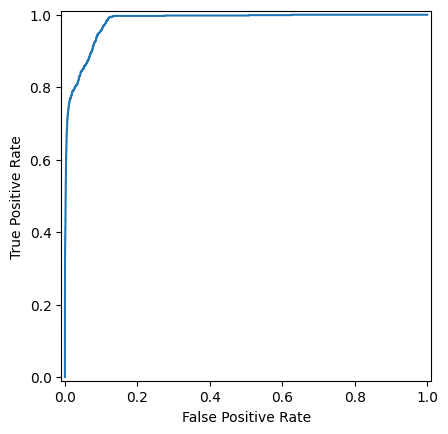

In [158]:
y_score = model.predict_proba(test_features)[:,1]

roc_auc = round(roc_auc_score(test_features_labels["is_laundering"], y_score), 4)
print("roc_auc_score =", roc_auc)
fpr, tpr, _ = roc_curve(test_features_labels["is_laundering"], y_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [159]:
%%time

CV_FOLD_PERC = 0.8
N_FOLDS = 5

f1_scores = []
for fold in range(N_FOLDS):
    print("Fold", fold + 1)
    x_train = train_features.sample(frac=CV_FOLD_PERC)
    x_train_labels = x_train.loc[:, []].join(train_features_labels, how="left")
    x_validation = validation_features.sample(frac=CV_FOLD_PERC)
    x_validation_labels = x_validation.loc[:, []].join(validation_features_labels, how="left")
    model_fold = train_model(
        x_train, x_train_labels["is_laundering"].values, 
        x_validation, x_validation_labels["is_laundering"].values,
        cv=True
    )
    y_test_predicted = model_fold.predict(test_features)
    f1_cv = f1_score(test_features_labels["is_laundering"], y_test_predicted) * 100
    print(
        round(f1_cv, 2),
        round(recall_score(test_features_labels["is_laundering"], y_test_predicted) * 100, 2)
    )
    f1_scores.append(f1_cv)

Fold 1
Best iteration: 30

37.83 27.89
Fold 2
Best iteration: 15

40.41 27.68
Fold 3
Best iteration: 15

38.39 27.24
Fold 4
Best iteration: 17

38.87 26.81
Fold 5
Best iteration: 13

38.7 27.03
CPU times: user 1h 16min 47s, sys: 1min 45s, total: 1h 18min 33s
Wall time: 10min 34s


In [160]:
gfp_best = 28.25
gfp_std = 0.80

In [161]:
print(f"GFP best: {gfp_best} ± {gfp_std}")

GFP best: 28.25 ± 0.8


In [162]:
print(f"{round(f1_final, 2)} ±{round(np.std(f1_scores), 2)}")

39.75 ±0.86


In [163]:
uplift = round(((f1_final - gfp_best) / gfp_best) * 100, 2)
print(f"Uplift of {uplift}%")

Uplift of 40.72%
